# Trabalho Computacional 3. Rede Convolucional e Transfer Learning

> **Nome**: *Gabriel Martins Silveira de Oliveira*.  
> **Matrícula**: 190042656.

# Verificação de Hardware

Antes de iniciarmos o trabalho, é fundamental definir alguns parâmetros para garantir a execução do notebook com o mínimo de interrupções. Inicialmente, considerou-se o uso da TPU (Tensor Processing Unit) do Google para otimizar os resultados. Contudo, essa opção não se mostrou prática devido à alta demanda e baixa disponibilidade desses recursos, dificultando o acesso.

Portanto, optaremos por utilizar apenas CUDA. Não é recomendado executar os experimentos utilizando somente a CPU. Caso esteja utilizando o Google Colab, recomenda-se fortemente o uso da GPU disponibilizada pela plataforma.

In [2]:
import os
import sys
import torch

IN_COLAB = "google.colab" in sys.modules
HAS_CUDA = torch.cuda.is_available()
NUM_CORES = os.cpu_count()
num_workers = NUM_CORES // 2 if NUM_CORES else 0
device_type = "gpu" if HAS_CUDA else "cpu"

colab_message = "Working in Google Colab\n" if IN_COLAB else ""
cuda_message = "Making use of CUDA\n" if HAS_CUDA else "No CUDA device found"
workers_message = f"With {num_workers} Workers"

print(colab_message + cuda_message + workers_message)

Working in Google Colab
Making use of CUDA
With 1 Workers


# Importações Essenciais

Recomenda-se a execução deste código no Google Colab. No entanto, caso deseje executá-lo localmente, o arquivo `pyproject.toml` foi disponibilizado para a correta instalação das dependências.

In [3]:
# Google colab dependencies
if IN_COLAB:
    import subprocess
    try:
        subprocess.run(
                ["pip", "install", "pytorch-lightning", "torchmetrics"], check=True
            )
        print("Successfully installed packages.")
    except subprocess.CalledProcessError as e:
        print(f"Error installing packages: {e}")

# PyTorch
import torch
from torch import nn, optim, Generator
from torch.utils.data import random_split, Subset, DataLoader

# TorchVision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import (
    vgg16,
    VGG16_Weights,
    inception_v3,
    Inception_V3_Weights,
)

# TorchMetrics
from torchmetrics.functional import accuracy

# TorchLightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Utils
from pathlib import Path
from argparse import Namespace
from typing import List, Tuple, cast, Literal

# Dataset

Neste trabalho, utilizaremos a base de dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

Ela é composta por 60.000 imagens coloridas de 32x32 pixels (3 canais de cor).

Inicialmente, as imagens serão mantidas em suas dimensões originais. Esta abordagem permitirá avaliar diferentes configurações preliminares e identificar as mais promissoras no contexto do modelo mais simples. Posteriormente, ao explorar arquiteturas mais complexas, como o VGG16, será realizado o redimensionamento das imagens. Para essa etapa, será aplicado um dos métodos de pré-processamento que apresentou o melhor desempenho com o modelo base. Embora essa estratégia não garanta, necessariamente, um impacto positivo idêntico no novo modelo, espera-se que haja uma correlação positiva, influenciando o processo de ajuste dos pesos da rede.

In [4]:
class CIFAR10Dataset:
    """I did some chances to this class to make it easier to work with"""
    train: Subset[datasets.CIFAR10]
    val: Subset[datasets.CIFAR10]
    test: datasets.CIFAR10
    classes: List[str]
    resize: Tuple[int, int]

    def __init__(
        self,
        root: Path = Path("./.data/"),
        resize: Tuple[int, int] = (32, 32),
    ):
        trans = transforms.Compose(
            [
                transforms.Resize(resize),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.5, 0.5, 0.5),
                    (0.5, 0.5, 0.5),
                ),
            ]
        )

        self.full_train = datasets.CIFAR10(
            root=root, train=True, transform=trans, download=True
        )

        self.classes = self.full_train.classes

        train_set_size = int(len(self.full_train) * 0.8)
        valid_set_size = len(self.full_train) - train_set_size

        seed = Generator().manual_seed(42)
        self.train, self.val = random_split(
            self.full_train, [train_set_size, valid_set_size], generator=seed
        )

        self.test = datasets.CIFAR10(
            root=root, train=False, transform=trans, download=True
        )

    def get_dataloader(
        self,
        dataset_type: Literal["train", "test", "val"],
        batch_size: int = 64,
        num_workers: int = 2,
        shuffle: bool = False,
        persistent_workers: bool = True,
        pin_memory=True,
    ) -> DataLoader:

        dataset: Subset[datasets.CIFAR10] = getattr(self, dataset_type)
        if dataset_type == "train":
            shuffle = True
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            persistent_workers=persistent_workers,
            pin_memory=pin_memory,
        )

In [5]:
root = Path("./.data/")
root.mkdir(parents=True, exist_ok=True)

In [ ]:
dataset = CIFAR10Dataset(root=root)
train_dataloader = dataset.get_dataloader(dataset_type="train", num_workers=num_workers, batch_size=1024)
val_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=1024)
test_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=1024)

In [ ]:
print(
    f"Number of training examples: {len(dataset.train):_}\n"
    f"Number of validation examples: {len(dataset.val):_}\n"
    f"Number of test examples: {len(dataset.test):_}\n\n"
    f"Number of Classes: {len(dataset.classes):_}\n"
    "Classes:",
    *dataset.classes,
    sep="\n  ",
)

Number of training examples: 40_000
Number of validation examples: 10_000
Number of test examples: 10_000

Number of Classes: 10
Classes:
  airplane
  automobile
  bird
  cat
  deer
  dog
  frog
  horse
  ship
  truck


Observa-se que o dataset é composto por 10 classes distintas. A divisão dos dados compreende 40.000 exemplos para treinamento, 10.000 para validação e 10.000 para teste. Abaixo, são apresentados alguns exemplos das imagens contidas neste conjunto.

In [ ]:
def imshow_batch(
    images_batch: torch.Tensor,
    labels_batch: torch.Tensor,
    class_names: List[str],
    mean: float = 0.5,
    std: float = 0.5,
    num_images_to_show: int = 9,
):
    images_batch = images_batch.cpu()

    axes_grid_array: np.ndarray

    _, axes_grid_array = plt.subplots(
        3, 3, figsize=(10, 10)
    )

    axes_flat_array = axes_grid_array.flatten()

    for i in range(min(num_images_to_show, len(images_batch))):
        ax = axes_flat_array[i]
        assert isinstance(ax, Axes), "Each element should be an Axes object" # Pylance...

        # We need to unnormalize the image ):
        img = images_batch[i]
        img = img * std + mean
        img = img.permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)

        ax.imshow(img.numpy())
        label_index: int = int(labels_batch[i].item())
        ax.set_title(f"Label: {class_names[label_index]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Displaying a batch of training images after transforms:


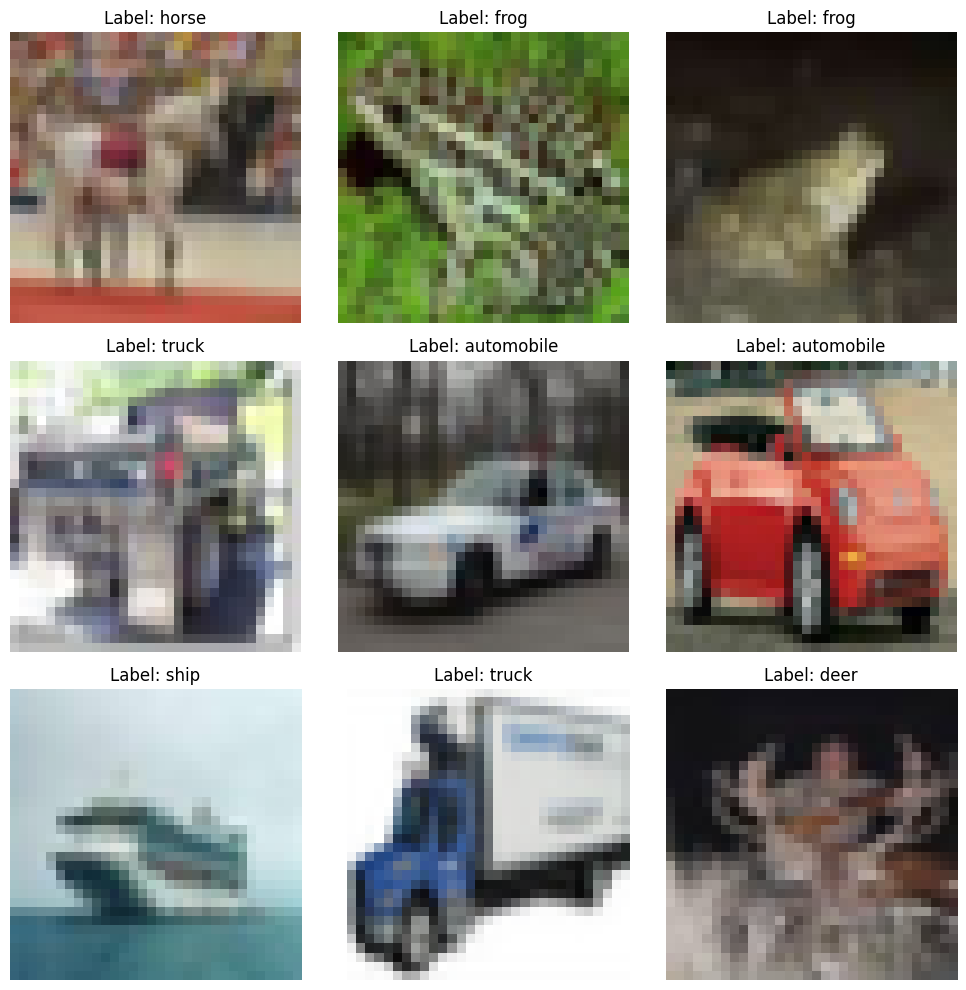

In [ ]:
data_iter = iter(test_dataloader)
try:
    images, labels = next(data_iter)

    print("Displaying a batch of training images after transforms:")
    imshow_batch(images, labels, dataset.classes, num_images_to_show=9)

except StopIteration:
    print("DataLoader is empty or could not fetch a batch.")

# Treinamento de uma MLP Simples

Nesta etapa, será realizado o treinamento de uma Rede Perceptron Multicamadas (MLP) básica, composta por duas camadas ocultas. Para otimizar e gerenciar o processo de treinamento, será utilizada a biblioteca `PyTorch Lightning`.

Uma rotina de treinamento foi customizada para simplificar a aplicação de técnicas de regularização, como L2, L1 e dropout. Contudo, funcionalidades essenciais da biblioteca `PyTorch Lightning`, como o mecanismo de `EarlyStopping` (parada antecipada) e a classe `Trainer` para a orquestração do ciclo de treinamento, continuarão a ser empregadas.

In [6]:
class ModelHParams(Namespace):
    lr: float
    num_classes: int
    weight_decay: float  # L2 Regularization
    l1_strength: float  # L1 Regularization


class LightModel(pl.LightningModule):
    model: nn.Module
    hparams: ModelHParams

    def __init__(
        self,
        model: nn.Module,
        lr: float = 1e-3,
        num_classes: int = 10,
        weight_decay: float = 0.0,  # No L2 regularization
        l1_strength: float = 0.0,  # No L1 regularization
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        X, y = batch
        y_hat: torch.Tensor = self(X)
        cross_entropy_loss = nn.functional.cross_entropy(y_hat, y)
        total_loss = cross_entropy_loss

        if self.hparams.l1_strength > 0:
            total_loss = self._deal_with_l1(total_loss)

        self.log(
            "train_loss",
            total_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            sync_dist=True,
        )

        return total_loss

    def _deal_with_l1(self, total_loss: torch.Tensor) -> torch.Tensor:
        l1_penalty = 0.0
        for param in self.model.parameters():
            if param.requires_grad:
                l1_penalty += torch.norm(param, 1)  # L1 norm
        total_loss += self.hparams.l1_strength * l1_penalty
        return total_loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        X, y = batch
        y_hat: torch.Tensor = self(X)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log(
            "val_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor]):
        X, y = batch
        y_hat: torch.Tensor = self(X)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(
            preds,
            y,
            task="multiclass",
            num_classes=self.hparams.get("num_classes", 10),
        )
        self.log("test_acc", acc, on_epoch=True)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log("test_loss", loss, on_epoch=True)

    def configure_optimizers(self) -> optim.Optimizer:
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        return optimizer

## Modelo Mais Simples

Este modelo inicial representa a configuração mais básica, sem a aplicação de técnicas de regularização L1 ou L2. Como função de ativação nas camadas ocultas, utiliza-se a ReLU.


In [ ]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)
mlp = LightModel(arch)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Dev\Coding\personal\Curso\ML\ENE0082\Trabalhos\Trabaho 3\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 


--- Training MLP classifier ---

Epoch 12: 100%|██████████| 625/625 [00:07<00:00, 80.22it/s, v_num=54, train_loss_step=1.420, val_loss=1.460, train_loss_epoch=1.130] 


In [ ]:
print("\n--- Testing MPL classifier ---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier ---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 120.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5020999908447266
        test_loss           1.4607789516448975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5020999908447266, 'test_loss': 1.4607789516448975}]

**Conclusões sobre o Modelo Simples**

A acurácia obtida com o modelo simples situa-se em aproximadamente 50%. Embora este valor possa ser considerado modesto, tal desempenho era, em certa medida, esperado, dada a simplicidade da arquitetura empregada frente à tarefa de classificação.

Contudo, alcançar este patamar de acurácia, especialmente ao considerar a complexidade intrínseca das imagens do dataset (CIFAR-10) e sua baixa resolução (32x32 pixels), pode ser interpretado como um resultado inicial promissor. Este desempenho indica que o modelo conseguiu aprender algumas características relevantes dos dados, estabelecendo uma linha de base para futuras otimizações e a exploração de arquiteturas mais elaboradas.

## Modelo MLP com Regularização L1

Mantendo a mesma arquitetura e os mesmos hiperparâmetros do [modelo mais simples](#modelo-mais-simples), este modelo diferencia-se pela introdução da regularização L1.

In [ ]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)
mlp = LightModel(arch, l1_strength=1e-5)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier L1 ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier L1 ---

Epoch 14: 100%|██████████| 625/625 [00:08<00:00, 73.09it/s, v_num=55, train_loss_step=1.380, val_loss=1.480, train_loss_epoch=1.240]


In [ ]:
print("\n--- Testing MPL classifier L1---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier L1---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 132.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4975999891757965
        test_loss           1.4784318208694458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4975999891757965, 'test_loss': 1.4784318208694458}]

**Conclusões sobre o Modelo Simples com Regularização L1**

Os resultados de acurácia obtidos são praticamente idênticos aos do modelo sem regularização. Contudo, observou-se um período de treinamento mais longo.

## Modelo MLP com Regularização L2

Mantendo a mesma arquitetura e os mesmos hiperparâmetros do [modelo mais simples](#modelo-mais-simples), este modelo diferencia-se pela introdução da regularização L2.

In [ ]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)
mlp = LightModel(arch, weight_decay=1e-5)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier L2 ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier L2 ---

Epoch 13: 100%|██████████| 625/625 [00:08<00:00, 77.24it/s, v_num=56, train_loss_step=1.140, val_loss=1.500, train_loss_epoch=1.120] 


In [ ]:
print("\n--- Testing MPL classifier L2---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier L2---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 140.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4950000047683716
        test_loss           1.5034754276275635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4950000047683716, 'test_loss': 1.5034754276275635}]

**Conclusões sobre o Modelo Simples com Regularização L2**

Os resultados de acurácia obtidos foram, em geral, consistentes com os dos dois testes precedentes. Tempo de treinamento inalterado.

### Experimento com Leaky ReLU

In [ ]:
arch_leaky = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 10),
)

mlp = LightModel(arch_leaky)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier Leaky ReLU---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier Leaky ReLU---

Epoch 10: 100%|██████████| 625/625 [00:07<00:00, 83.00it/s, v_num=57, train_loss_step=1.140, val_loss=1.430, train_loss_epoch=1.170] 


In [ ]:
print("\n--- Testing MPL classifier Leaky ReLU---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier Leaky ReLU---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 137.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5091999769210815
        test_loss           1.4291560649871826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5091999769210815, 'test_loss': 1.4291560649871826}]

**Conclusões sobre o Experimento com Leaky ReLU**

Os resultados de desempenho foram similares aos obtidos em experimentos anteriores. Contudo, observou-se uma ligeira redução no tempo de treinamento.

## Modelo MLP com Dropout

Serão utilizados os mesmos parâmetros do [modelo simples](#modelo-mais-simples). Contudo, nesta iteração, será aplicada a técnica de Dropout com uma probabilidade de 50%, a fim de observar e analisar o impacto nos resultados.

In [ ]:
dropout_p = 0.5
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Dropout(p=dropout_p),
    nn.Linear(16, 10),
)

mlp = LightModel(arch)


early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier Dropout---\n")

trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 197 K  | train
---------------------------------------------
197 K     Trainable params
0         Non-trainable params
197 K     Total params
0.792     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier Dropout---

Epoch 38: 100%|██████████| 625/625 [00:12<00:00, 49.66it/s, v_num=58, train_loss_step=1.810, val_loss=1.620, train_loss_epoch=1.760] 


In [ ]:
print("\n--- Testing MPL classifier Dropout---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier Dropout---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 130.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4189999997615814
        test_loss           1.6188361644744873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.4189999997615814, 'test_loss': 1.6188361644744873}]

**Conclusões sobre a MLP Simples com Dropout**

Observou-se um tempo de treinamento consideravelmente estendido, e a acurácia apresentou uma queda significativa. Esse resultado pode indicar que, para a arquitetura em questão, o Dropout não é a técnica de regularização mais adequada, visto que a simplicidade do modelo não demanda a aplicação dessa ferramenta.

## Variação do Número de Neurônios na MLP

Nesta etapa, será realizada a variação do número de neurônios nas camadas da MLP com o objetivo de identificar a configuração que otimize a acurácia do modelo.

In [ ]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
)

mlp = LightModel(arch)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 803 K  | train
---------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier ---

Epoch 8: 100%|██████████| 625/625 [00:08<00:00, 74.68it/s, v_num=59, train_loss_step=1.070, val_loss=1.460, train_loss_epoch=0.965] 


In [ ]:
print("\n--- Testing MPL classifier ---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier ---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 112.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5278000235557556
        test_loss           1.4579455852508545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5278000235557556, 'test_loss': 1.4579455852508545}]

**Conclusões sobre a Variação do Número de Neurônios**

Após uma série de experimentos, constatou-se que a configuração com 256 neurônios na primeira camada oculta e 64 neurônios na segunda resultou em um equilíbrio favorável entre acurácia e tempo de treinamento.

## Modelo MLP com Melhores Técnicas

Nesta etapa, serão aplicadas as melhores técnicas identificadas em experimentos anteriores, com o objetivo de otimizar o tempo de treinamento e maximizar a precisão. Isso inclui a utilização da função de ativação Leaky ReLU e a configuração do número ótimo de neurônios, conforme determinado previamente.

In [ ]:
arch = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10),
)

mlp = LightModel(arch)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training MLP classifier Best Techs ---\n")
trainer.fit(
    model=mlp, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 803 K  | train
---------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.215     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



--- Training MLP classifier Best Techs ---

Epoch 10: 100%|██████████| 625/625 [00:08<00:00, 73.06it/s, v_num=60, train_loss_step=0.645, val_loss=1.530, train_loss_epoch=0.855]


In [ ]:
print("\n--- Testing MPL classifier Best Techs---\n")
trainer.test(model=mlp, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing MPL classifier Best Techs---

Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 118.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5249999761581421
        test_loss           1.5264487266540527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.5249999761581421, 'test_loss': 1.5264487266540527}]

**Conclusões sobre a MLP com as Melhores Técnicas**

O tempo de treinamento transcorreu conforme o esperado, e a acurácia, por sua vez, mostrou-se bastante satisfatória.

## Uso da Rede VGG16 Pré-treinada

Nesta etapa, será empregada uma rede pré-treinada: a VGG16. A seguir, um diagrama ilustra sua arquitetura.

Será realizada a modificação da camada classificadora da rede VGG16. A arquitetura VGG16 pré-treinada exige como entrada imagens com dimensões de 244x244 pixels e 3 canais de cor. Consequentemente, será necessário redimensionar o dataset para se adequar a este requisito.

Para otimizar o processo de treinamento, **será empregada a função de ativação Leaky ReLU**, uma vez que experimentos anteriores indicaram um aumento na velocidade de treinamento. Em contrapartida, **o Dropout não será aplicado**, pois testes prévios com modelos de menor complexidade demonstraram que essa técnica não resultou em benefícios significativos.

Abaixo, um diagrama ilustra a estrutura da nova camada classificadora que será definida. Além disso, as classes de saída também precisarão ser ajustadas para corresponder ao nosso problema de classificação.

### Ajustar dataset Resize 244 x 244

In [5]:
dataset = CIFAR10Dataset(root=root, resize=(244, 244))
train_dataloader = dataset.get_dataloader(dataset_type="train", num_workers=num_workers, batch_size=256)
val_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=256)
test_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=256)

### Requisição de Modelo

In [6]:
model_vgg = vgg16(weights=VGG16_Weights.DEFAULT, progress=True)

for param in model_vgg.parameters():
    param.requires_grad = False

in_features = cast(int, model_vgg.classifier[0].in_features)

### Classifier Costumizado

In [9]:
custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10)
)
model_vgg.classifier = custom_classifier

light_vgg_model = LightModel(model=model_vgg)

In [10]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping], max_epochs=50, accelerator=device_type, devices=1
)
print("\n--- Training VGG16 with custom classifier ---\n")
trainer.fit(
    model=light_vgg_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



--- Training VGG16 with custom classifier ---



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VGG  | 17.9 M | train
---------------------------------------
3.2 M     Trainable params
14.7 M    Non-trainable params
17.9 M    Total params
71.740    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
print("\n--- Testing VGG16 with custom classifier ---\n")
trainer.test(model=light_vgg_model, dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing VGG16 with custom classifier ---



Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8547999858856201     │
│         test_loss         │    0.7108144164085388     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8547999858856201, 'test_loss': 0.7108144164085388}]

## Conclusões sobre o Modelo VGG16

O tempo de treinamento para o modelo VGG16 foi considerável, contudo, razoável, dadas as otimizações realizadas, totalizando 35 minutos em 6 épocas. Uma acurácia de 85% foi alcançada, resultado que se mostrou satisfatório.

Embora ajustes potenciais nos parâmetros das camadas de entrada e saída da camada classificadora pudessem, em tese, resultar em uma acurácia ligeiramente superior (atingindo até 87%), a manutenção de um processo de treinamento tão prolongado para tal otimização foi considerada inviável.

Portanto, a acurácia de 85% é aceita como um resultado adequado para os propósitos deste estudo, considerando o *trade-off* entre desempenho e custo computacional.

## Modelo Inception V3 da Google

Nesta etapa, serão aplicadas as mesmas técnicas ao modelo Inception V3.

O modelo Inception V3 representa uma escolha adequada para esta aplicação, dada a sua natureza predominantemente convolucional e a simplicidade de sua camada de saída linear. Essas características sugerem uma boa capacidade de generalização para o dataset CIFAR-10, mesmo com uma entrada de complexidade relativamente menor em comparação aos dados de pré-treinamento.

## Redimensionamento do Dataset para 299x299 Pixels

Nesta etapa, o dataset será redimensionado para que as imagens possuam as dimensões de 299x299 pixels, tornando-as compatíveis com a entrada esperada pelo modelo Inception V3.

Dada a alta demanda computacional deste modelo e a limitação de 4 GB de VRAM do sistema, será necessário reduzir o tamanho do *batch*.

In [13]:
dataset = CIFAR10Dataset(root=root, resize=(299, 299))
train_dataloader = dataset.get_dataloader(dataset_type="train", num_workers=num_workers, batch_size=450)
val_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=450)
test_dataloader = dataset.get_dataloader(dataset_type="val", num_workers=num_workers, batch_size=450)

In [14]:
model_inception = inception_v3(weights=Inception_V3_Weights.DEFAULT, progress=True)
model_inception.aux_logits = False

for param in model_inception.parameters():
    param.requires_grad = False

in_features_inception = model_inception.fc.in_features

custom_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features_inception, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 10)
)

# Pylance will complain about the data type, fc is Linear
model_inception.fc = custom_classifier  # type: ignore

light_inception_model = LightModel(model_inception)

In [15]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=0.001,
)
trainer = Trainer(
    callbacks=[early_stopping],
    max_epochs=50,
    accelerator=device_type,
    devices=1,
    # accumulate_grad_batches=2, # If were to reduce more batch size
)
print("\n--- Training Inception with custom classifier ---\n")
trainer.fit(
    model=light_inception_model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Inception3 | 25.4 M | train
---------------------------------------------
271 K     Trainable params
25.1 M    Non-trainable params
25.4 M    Total params
101.534   Total estimated model params size (MB)
313       Modules in train mode
0         Modules in eval mode



--- Training Inception with custom classifier ---



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [16]:
print("\n--- Testing Inception with custom classifier ---\n")
trainer.test(model=light_inception_model, dataloaders=test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Testing Inception with custom classifier ---



Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7818999886512756     │
│         test_loss         │    0.6332271695137024     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7818999886512756, 'test_loss': 0.6332271695137024}]

## Conclusões sobre o Modelo Inception V3 da Google

O treinamento do modelo Inception V3 estendeu-se por mais de uma hora, ultrapassando 22 épocas, o que foi considerado um tempo inaceitável.

A convergência deste modelo mostrou-se excessivamente gradual. Embora o ajuste de hiperparâmetros pudesse otimizar o processo, as restrições de tempo inviabilizaram tal abordagem.

Ao término do período de treinamento, a acurácia alcançada foi de 78%. Este resultado é passível de melhoria, dado que o treinamento foi interrompido antes de sua conclusão, em virtude de sua lentidão excessiva.

Ajustes no parâmetro `weight_decay` foram realizados; contudo, não foram percebidas diferenças significativas. Mesmo com a aplicação de um `weight_decay` agressivo, o tempo de treinamento sempre ultrapassou 7 épocas, e a acurácia foi pouco alterada. Devido à complexidade deste modelo, em que a maior parte de sua lógica reside na camada convolucional, não se deve esperar que a adição de uma camada classificadora final para adaptar o modelo ao reconhecimento de nossos objetos resulte em um ganho extremamente significativo. Originalmente, o modelo empregava apenas uma camada linear para mapear as saídas das camadas convolucionais às suas respectivas classes.